In [9]:
#SI 370 Final Project: NFL Play-By-Play Analysis

In [10]:
import pandas as pd
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
import sklearn.preprocessing as skp
import sklearn.decomposition as skd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.spatial.distance as spd
import scipy.cluster.hierarchy as sph
import sklearn.manifold as manifold
import sklearn.cluster as skc
import sklearn.metrics as skm
import seaborn as sns
from scipy import stats
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
sns.set_context("paper")
from pylab import rcParams
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = 12, 12
from statsmodels.graphics.mosaicplot import mosaic

In [11]:
#Loading in dataset
pd_pbp = pd.read_csv('pbp-2016.csv')

In [58]:
pd_pbp.head()

,GameId,GameDate,Quarter,Minute,Second,OffenseTeam,DefenseTeam,Down,ToGo,YardLine,...,IsTwoPointConversion,IsTwoPointConversionSuccessful,RushDirection,YardLineFixed,YardLineDirection,IsPenaltyAccepted,PenaltyTeam,IsNoPlay,PenaltyType,PenaltyYards
0,2016090800,2016-09-08,1,0,0,NaN,CAR,0,0,0,...,0,0,NaN,0,OWN,0,NaN,0,NaN,0
1,2016090800,2016-09-08,4,2,0,NaN,CAR,0,0,0,...,0,0,NaN,0,OWN,0,NaN,0,NaN,0
2,2016091100,2016-09-11,4,6,18,NaN,TB,0,0,0,...,0,0,NaN,0,OWN,0,NaN,0,NaN,0
3,2016091100,2016-09-11,4,0,0,NaN,TB,0,0,0,...,0,0,NaN,0,OWN,0,NaN,0,NaN,0
4,2016091101,2016-09-11,2,0,0,NaN,BUF,0,0,0,...,0,0,NaN,0,OWN,0,NaN,0,NaN,0


In [13]:
#Sorted dataframe that removes rows that contain playtypes that don't yield yards through masking
pd_pbp_sorted = pd_pbp.sort_values(['GameId', 'Quarter', 'Minute', 'Second'], ascending=True)
pd_pbp_sorted = pd_pbp_sorted[(pd_pbp_sorted.PlayType != 'KICK OFF') & (pd_pbp_sorted.PlayType != 'PUNT') & 
                              (pd_pbp_sorted.PlayType != 'FUMBLES') & (pd_pbp_sorted.PlayType != 'TIMEOUT') &
                              (pd_pbp_sorted.PlayType != 'CLOCK STOP') & (pd_pbp_sorted.PlayType != 'FIELD GOAL') &
                              (pd_pbp_sorted.PlayType != 'NO PLAY') & (pd_pbp_sorted.PlayType != 'QB KNEEL') &
                              (pd_pbp_sorted.PlayType != 'TWO-POINT CONVERSION') & (pd_pbp_sorted.PlayType != 'PENALTY') &
                              (pd_pbp_sorted.PlayType != 'EXCEPTION') & (pd_pbp_sorted.PlayType != 'NaN')]
pd_pbp_sorted = pd_pbp_sorted[pd_pbp_sorted.PlayType != "EXTRA POINT"]

In [56]:
#Tableau Histograms

In [14]:
#Groups dataframe by each game, the team on defense, the type of play, and aggregates the yards for each play type.
pd_pbp_sorted_defense = pd_pbp_sorted.groupby(['GameId','GameDate','DefenseTeam','PlayType'])['Yards'].sum()
pd_pbp_sorted_defense = pd_pbp_sorted_defense.to_frame()

In [15]:
#Save this dataframe to csv to import into Tableau
pd_pbp_sorted_defense.to_csv('DefenseYards.csv')

In [16]:
#Groups dataframe by each game, the team on defense, the type of play, and aggregates the yards for each play type.
pd_pbp_sorted_offense = pd_pbp_sorted.groupby(['GameId','GameDate','OffenseTeam','PlayType'])['Yards'].sum()
pd_pbp_sorted_offense = pd_pbp_sorted_offense.to_frame()

In [17]:
#Save this dataframe to csv to import into Tableau
pd_pbp_sorted_offense.to_csv('OffenseYards.csv')

In [57]:
#Mosaic PLots/Contingency Tables/Heatmaps

In [18]:
#Creating mosaic plot for passing plays between the two Superbowl teams
pd_pbp_mosaic = pd_pbp[(pd_pbp.PlayType == 'PASS') & (pd_pbp.PassType == 'DEEP LEFT') |
                 (pd_pbp.PassType == 'DEEP MIDDLE') | (pd_pbp.PassType == 'DEEP RIGHT') |
                 (pd_pbp.PassType == 'SHORT LEFT') | (pd_pbp.PassType == 'SHORT MIDDLE') |
                 (pd_pbp.PassType == 'SHORT RIGHT')]
pd_pbp_mosaic_test = pd_pbp_mosaic[(pd_pbp_mosaic.OffenseTeam == 'NE') | (pd_pbp_mosaic.OffenseTeam == 'ATL')]

In [19]:
#Contingency table for passing plays
pd_pbp_aerial = pd_pbp[(pd_pbp.PlayType == 'PASS') & (pd_pbp.PassType == 'DEEP LEFT') |
                 (pd_pbp.PassType == 'DEEP MIDDLE') | (pd_pbp.PassType == 'DEEP RIGHT') |
                 (pd_pbp.PassType == 'SHORT LEFT') | (pd_pbp.PassType == 'SHORT MIDDLE') |
                 (pd_pbp.PassType == 'SHORT RIGHT')]
pd_pbp_aerial = pd.crosstab(pd_pbp_aerial['OffenseTeam'], pd_pbp_aerial['PassType'])
pd_pbp_aerial.head()

PassType,DEEP LEFT,DEEP MIDDLE,DEEP RIGHT,SHORT LEFT,SHORT MIDDLE,SHORT RIGHT
OffenseTeam,,,,,,
ARI,54,31,53,208,137,206
ATL,46,28,36,153,114,187
BAL,24,39,48,158,220,222
BUF,37,9,65,156,66,171
CAR,45,29,56,161,88,217


In [20]:
#Correlations for passing plays
pd_pbp_aerial.corr()

PassType,DEEP LEFT,DEEP MIDDLE,DEEP RIGHT,SHORT LEFT,SHORT MIDDLE,SHORT RIGHT
PassType,,,,,,
DEEP LEFT,1.000000,0.331295,0.165372,0.237883,-0.103728,-0.239975
DEEP MIDDLE,0.331295,1.000000,0.358776,0.054335,0.520800,0.019796
DEEP RIGHT,0.165372,0.358776,1.000000,0.097012,0.092541,-0.058402
SHORT LEFT,0.237883,0.054335,0.097012,1.000000,0.155356,0.136809
SHORT MIDDLE,-0.103728,0.520800,0.092541,0.155356,1.000000,0.156055
SHORT RIGHT,-0.239975,0.019796,-0.058402,0.136809,0.156055,1.000000


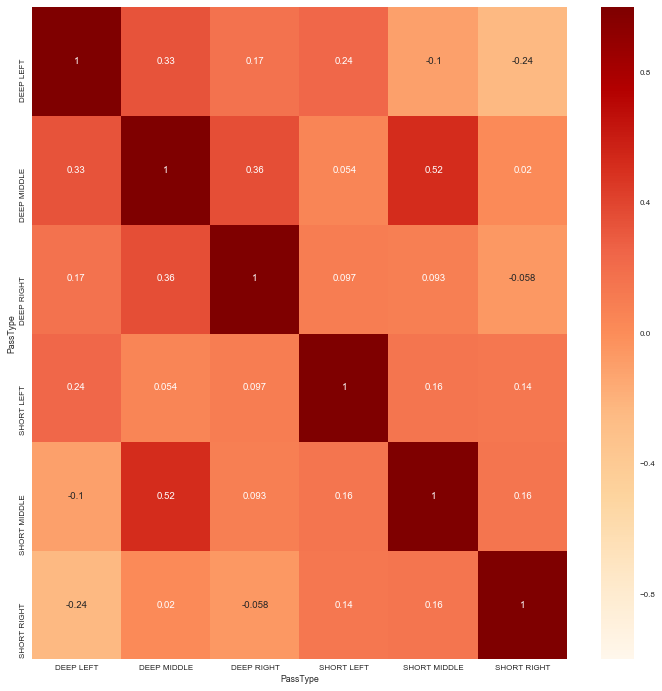

In [21]:
#Heatmap for passing plays
sns.heatmap(pd_pbp_aerial.corr(), cmap=plt.cm.OrRd, annot=True)

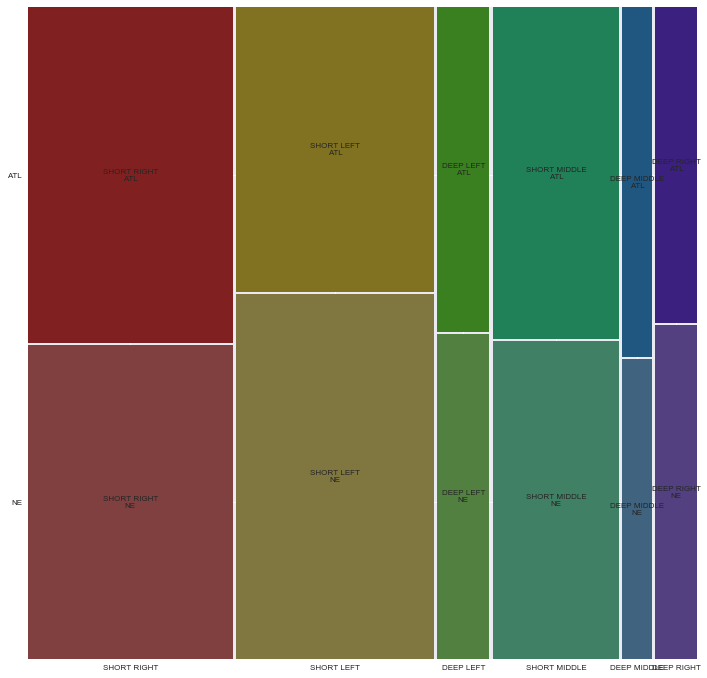

In [22]:
#Mosaic plot between NE and ATL passing offense
plot = mosaic(pd_pbp_mosaic_test, ['PassType', 'OffenseTeam'])

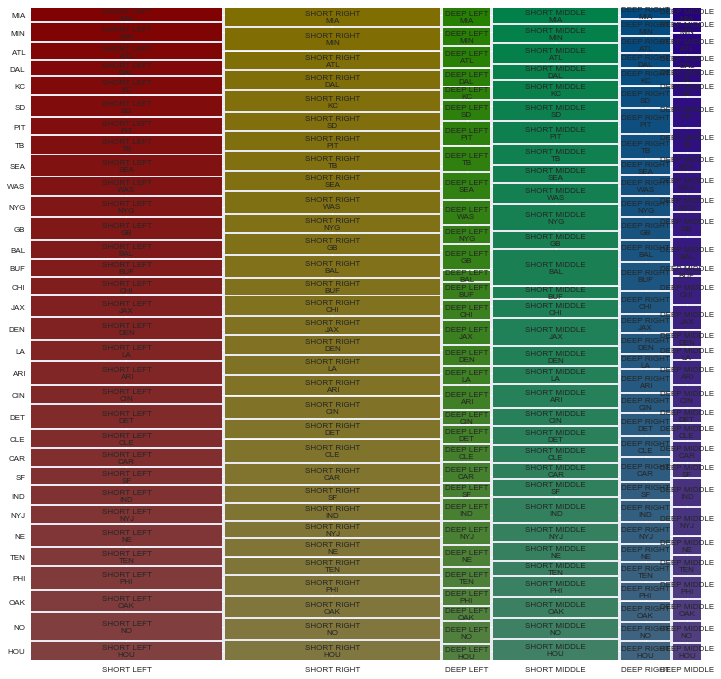

In [23]:
#Mosaic plot between all NFL team's passing offense
plot = mosaic(pd_pbp_mosaic, ['PassType', 'OffenseTeam'])

In [24]:
#Creating mosaic plot for rushing patterns between the two Superbowl teams
pd_pbp_mosaic_rush = pd_pbp[(pd_pbp.PlayType == 'RUSH')]
pd_pbp_mosaic_rush_test = pd_pbp_mosaic_rush[(pd_pbp_mosaic_rush.OffenseTeam == 'NE') | (pd_pbp_mosaic_rush.OffenseTeam == 'ATL')]

In [25]:
#Contingency table for rushing offense
pd_pbp_rush = pd_pbp[(pd_pbp.PlayType == 'RUSH')]
pd_pbp_rush = pd.crosstab(pd_pbp_rush['OffenseTeam'], pd_pbp_rush['RushDirection'])
pd_pbp_rush.head()

RushDirection,CENTER,LEFT END,LEFT GUARD,LEFT TACKLE,RIGHT END,RIGHT GUARD,RIGHT TACKLE
OffenseTeam,,,,,,,
ARI,162,38,27,56,35,15,52
ATL,56,66,47,47,64,65,54
BAL,50,31,83,32,24,76,56
BUF,102,55,51,51,52,60,61
CAR,135,49,59,36,35,74,57


In [26]:
#Correlations for rushing plays
pd_pbp_rush.corr()

RushDirection,CENTER,LEFT END,LEFT GUARD,LEFT TACKLE,RIGHT END,RIGHT GUARD,RIGHT TACKLE
RushDirection,,,,,,,
CENTER,1.000000,-0.265890,-0.306230,-0.239129,-0.234062,-0.457218,-0.211760
LEFT END,-0.265890,1.000000,-0.213737,0.079675,0.660437,-0.153138,-0.074354
LEFT GUARD,-0.306230,-0.213737,1.000000,0.272509,-0.505270,0.770419,0.269855
LEFT TACKLE,-0.239129,0.079675,0.272509,1.000000,-0.081518,0.227295,0.670202
RIGHT END,-0.234062,0.660437,-0.505270,-0.081518,1.000000,-0.333379,-0.186271
RIGHT GUARD,-0.457218,-0.153138,0.770419,0.227295,-0.333379,1.000000,0.321923
RIGHT TACKLE,-0.211760,-0.074354,0.269855,0.670202,-0.186271,0.321923,1.000000


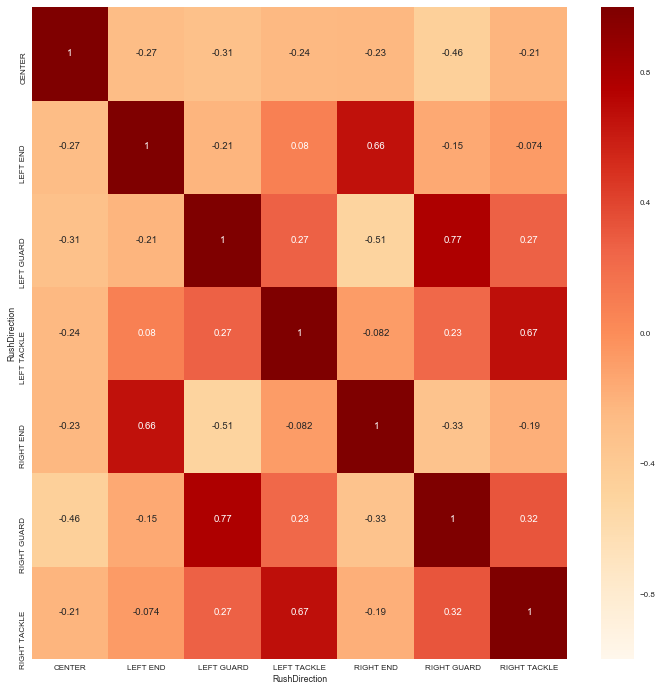

In [28]:
#Heatmap for rushing plays
sns.heatmap(pd_pbp_rush.corr(), cmap=plt.cm.OrRd, annot=True)

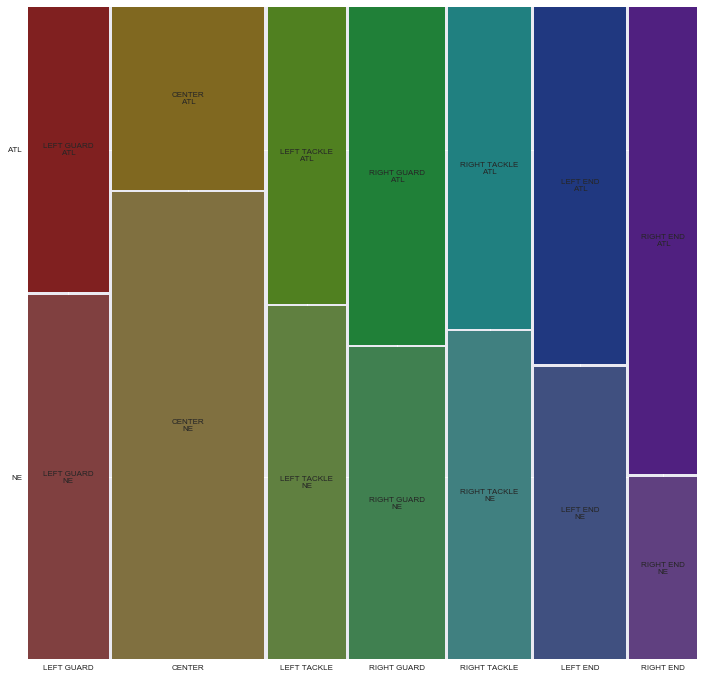

In [29]:
#Mosaic plot for the rushing patterns between NE and ATL
plot = mosaic(pd_pbp_mosaic_rush_test, ['RushDirection', 'OffenseTeam'])

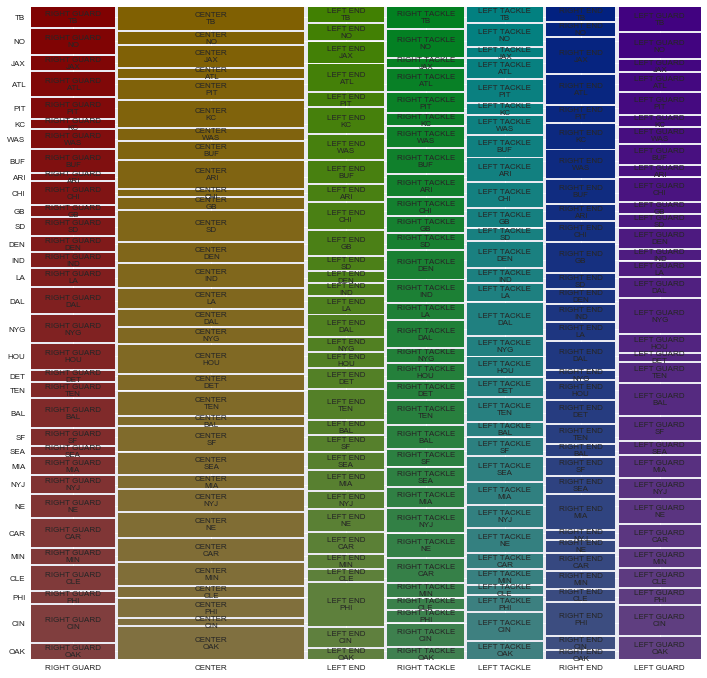

In [30]:
#Mosaic plot for all of the NFL teams rushing patterns
plot = mosaic(pd_pbp_mosaic_rush, ['RushDirection', 'OffenseTeam'])

In [55]:
#PCA Models

In [60]:
#Normalizing the rushing patterns using z-score
pd_pbp_rush_norm = pd_pbp_rush.copy()
pd_pbp_rush_norm.ix[:,:8] = skp.scale(pd_pbp_rush_norm.ix[:,:8].astype(np.float))
pd_pbp_rush_norm.head()

RushDirection,CENTER,LEFT END,LEFT GUARD,LEFT TACKLE,RIGHT END,RIGHT GUARD,RIGHT TACKLE
OffenseTeam,,,,,,,
ARI,1.224188,-0.470075,-1.289386,0.835975,-0.391698,-1.872653,0.498362
ATL,-1.329592,1.228260,-0.117217,0.142140,1.355877,0.790676,0.653948
BAL,-1.474145,-0.894659,1.992687,-1.014252,-1.054571,1.376608,0.809534
BUF,-0.221348,0.561057,0.117217,0.450511,0.632743,0.524343,1.198499
CAR,0.573697,0.197128,0.586085,-0.705881,-0.391698,1.270075,0.887327


In [61]:
# There are 7 components extracted from the data; each component is
# a 7-dimensional vector.
pca_model = skd.PCA().fit(pd_pbp_rush_norm.ix[:,:8])
pca_model.components_.shape

(7, 7)

In [62]:
# Look at the variances explained by each component.
# These values equal to the eigenvalues of the correlation matrix.
pca_model.explained_variance_

array([ 2.71240288,  1.83860056,  1.1847336 ,  0.50267037,  0.3358635 ,
        0.254813  ,  0.17091609])

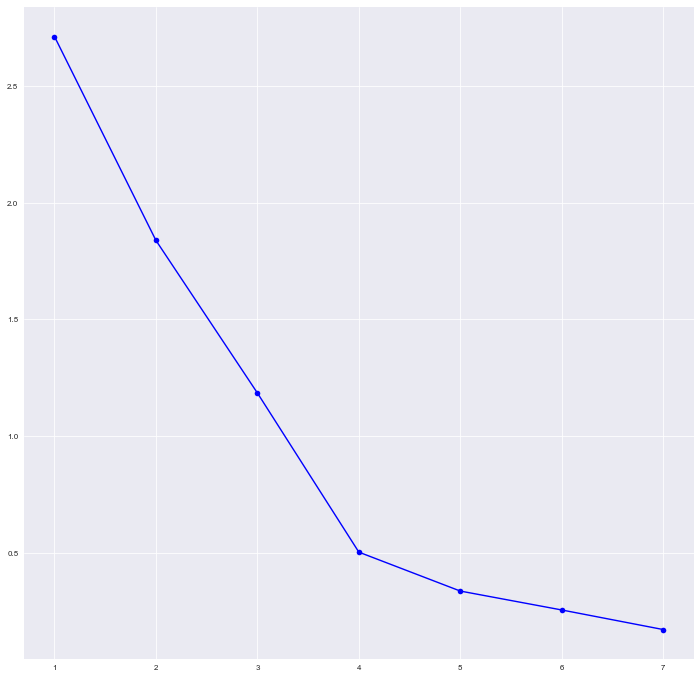

In [63]:
# A "scree" plot of the rushing patterns
plt.plot(range(1,8),pca_model.explained_variance_,'b-o')

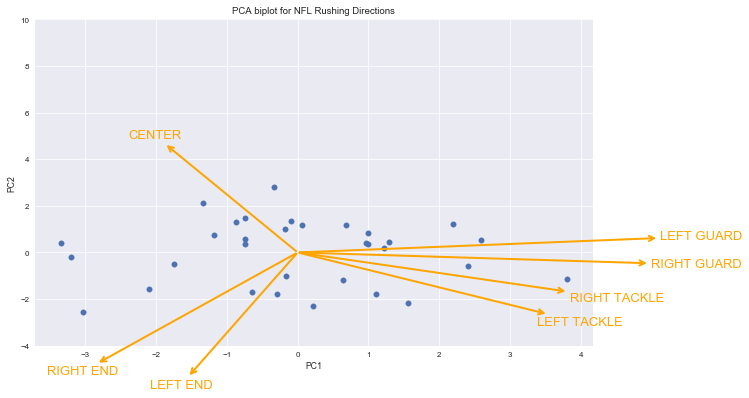

In [64]:
# Scatterplot of disaggregated rushing data
X = pca_model.transform(pd_pbp_rush_norm.ix[:,:8])
plt.figure(figsize=(10,6))
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot for NFL Rushing Directions')
plt.ylim(-4, 10)

# Add variable unit vector projections
V = pca_model.transform(np.identity(X.shape[1]))
for i, v in enumerate(V):
    plt.annotate(pd_pbp_rush_norm.columns[i], 
                 xy=(0,0), xytext=v[:2]*10, 
                 fontsize=13, color='orange',
                 arrowprops=dict(
                    arrowstyle='<-', linewidth=2, color='orange'))

In [65]:
#Normalizing the rushing patterns using z-score
pd_pbp_aerial_norm = pd_pbp_aerial.copy()
pd_pbp_aerial_norm.ix[:,:7] = skp.scale(pd_pbp_aerial_norm.ix[:,:7].astype(np.float))
pd_pbp_aerial_norm.head()

PassType,DEEP LEFT,DEEP MIDDLE,DEEP RIGHT,SHORT LEFT,SHORT MIDDLE,SHORT RIGHT
OffenseTeam,,,,,,
ARI,1.168107,0.681708,0.991608,1.279385,0.791275,0.421627
ATL,0.296284,0.305593,-1.013725,-0.930347,-0.047887,-0.603769
BAL,-2.101230,1.684682,0.401804,-0.729463,3.819555,1.285118
BUF,-0.684517,-2.076468,2.407137,-0.809817,-1.799181,-1.467260
CAR,0.187306,0.430965,1.345490,-0.608932,-0.996505,1.015277


In [66]:
# There are 6 components extracted from the data; each component is
# a 6-dimensional vector.
pca_model = skd.PCA().fit(pd_pbp_aerial_norm.ix[:,:7])
pca_model.components_.shape

(6, 6)

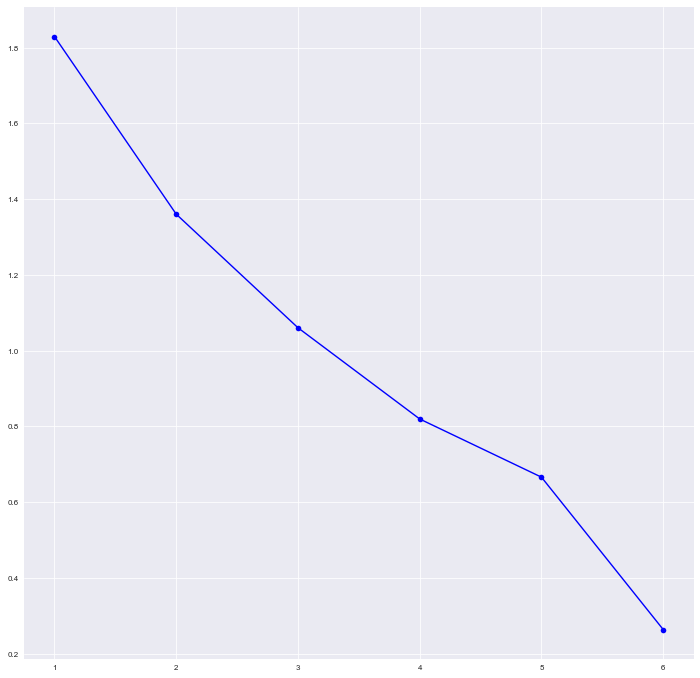

In [67]:
# A "scree" plot of the passing data
plt.plot(range(1,7),pca_model.explained_variance_,'b-o')

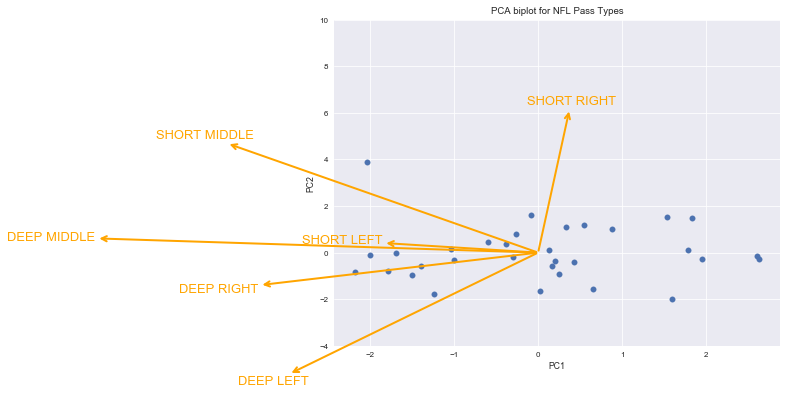

In [68]:
# Scatterplot of disaggregated passing data
X = pca_model.transform(pd_pbp_aerial_norm.ix[:,:7])
plt.figure(figsize=(8,6))
plt.scatter(X[:,0], X[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA biplot for NFL Pass Types')
plt.ylim(-4, 10)

# Add variable unit vector projections
V = pca_model.transform(np.identity(X.shape[1]))
for i, v in enumerate(V):
    plt.annotate(pd_pbp_aerial_norm.columns[i], 
                 xy=(0,0), xytext=v[:2]*10, 
                 fontsize=13, color='orange',
                 arrowprops=dict(
                    arrowstyle='<-', linewidth=2, color='orange'))

In [44]:
#Clustering

In [40]:
#Creating dataframe of the passing/rushing ditributions for each NFL team
pd_playtype = pd_pbp_sorted.groupby(['OffenseTeam', 'PlayType'])['Yards'].count()
pd_playtype = pd_playtype.unstack('PlayType')
pd_playtype = pd_playtype[['PASS', 'RUSH']]
pd_playtype

PlayType,PASS,RUSH
OffenseTeam,,
ARI,691,385
ATL,564,399
BAL,711,352
BUF,504,432
CAR,596,445
CHI,594,365
CIN,591,413
CLE,598,270
DAL,505,468


In [41]:
#transforming data into x/y coordinates
coords = manifold.MDS(n_components=2).fit_transform(pd_playtype)
x= [d[0] for d in coords]
y= [d[1] for d in coords]

In [45]:
#K-means clustering of data using k=2
kmeans_model = skc.KMeans(2).fit(pd_playtype)
pd_playtype['x'] = x
pd_playtype['y'] = y
pd_playtype['cluster_label'] = kmeans_model.labels_
pd_playtype_clust = pd_playtype
pd_playtype_clust['cluster_label'] = kmeans_model.labels_
pd_playtype

PlayType,PASS,RUSH,x,y,cluster_label
OffenseTeam,,,,,
ARI,691,385,87.198670,-5.385228,1
ATL,564,399,-40.543450,-6.706306,0
BAL,711,352,110.331997,25.643097,1
BUF,504,432,-103.652257,-33.191996,0
CAR,596,445,-13.353561,-55.659385,0
CHI,594,365,-7.293890,24.131715,1
CIN,591,413,-15.089337,-23.342904,0
CLE,598,270,6.101637,118.298130,1
DAL,505,468,-106.728947,-68.571624,0


In [46]:
#finding centroids of both clusters
centroids_mds = pd_playtype_clust.groupby('cluster_label').mean()[['x','y']].as_matrix()

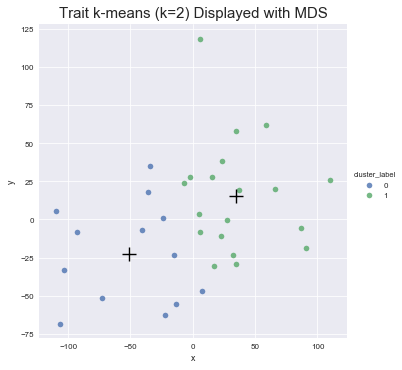

In [47]:
#Scatter plot with both clusters
f = sns.lmplot(x='x', y='y', data=pd_playtype_clust, 
               hue='cluster_label',
               fit_reg=False)
f.ax.scatter(centroids_mds[:,0], 
             centroids_mds[:,1], 
             marker='+', s=200,
             linewidths=2, color='black');
plt.title('Trait k-means (k=2) Displayed with MDS', 
          fontsize=15);

In [48]:
X = pd_playtype.copy()  # Using the playtype dataframe
K = range(1,5)  # Apply kmeans 1 to 5

In [49]:
# create one model for each k
kmeans_models = [skc.KMeans(k).fit(X) for k in K]

# find the centroids for each model
centroids = [m.cluster_centers_ for m in kmeans_models]

# calculate the distance of every point
D_k = [spd.cdist(X,cent,'euclidean') for cent in centroids]

# find the min distance
cIdx = [np.argmin(D,axis=1) for D in D_k]
dist = [np.min(D,axis=1) for D in D_k]

# calculate sum of squares
avgWithinSS = [sum(d)/X.shape[0] for d in dist]

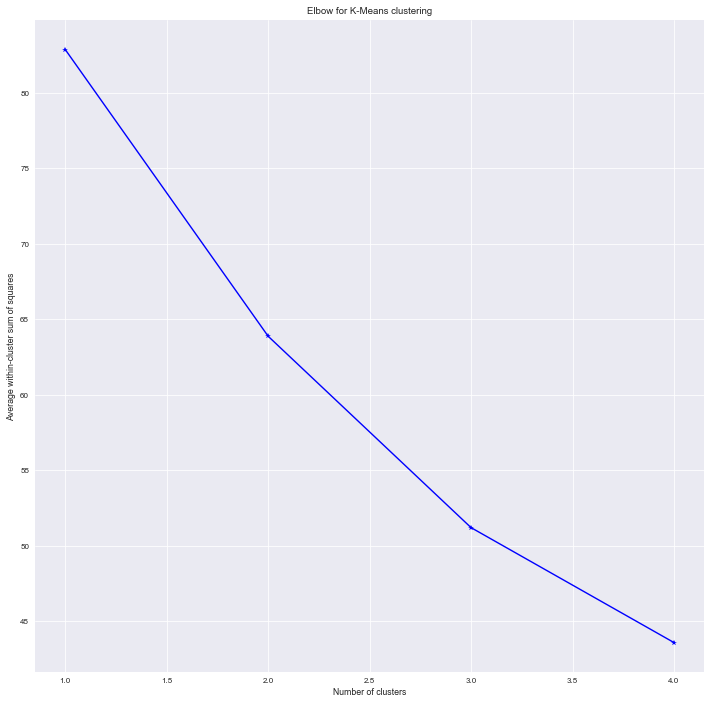

In [51]:
# plot elbow curve showing k=3
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');

In [52]:
#K-means clustering of data using k=3
kmeans_model = skc.KMeans(3).fit(pd_playtype_clust)
playtype_clust = pd_playtype
playtype_clust['cluster_label'] = kmeans_model.labels_
playtype_clust

PlayType,PASS,RUSH,x,y,cluster_label
OffenseTeam,,,,,
ARI,691,385,87.198670,-5.385228,0
ATL,564,399,-40.543450,-6.706306,2
BAL,711,352,110.331997,25.643097,0
BUF,504,432,-103.652257,-33.191996,1
CAR,596,445,-13.353561,-55.659385,2
CHI,594,365,-7.293890,24.131715,2
CIN,591,413,-15.089337,-23.342904,2
CLE,598,270,6.101637,118.298130,0
DAL,505,468,-106.728947,-68.571624,1


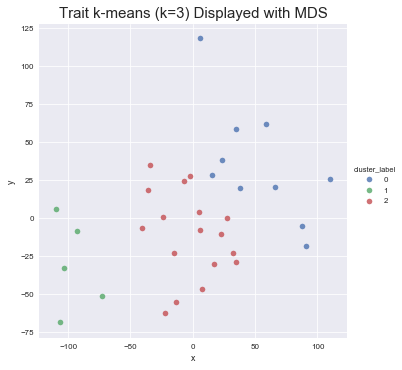

In [54]:
#Scatterplot of data with three clusters
f = sns.lmplot(x='x', y='y', data=playtype_clust, 
               hue='cluster_label',
               fit_reg=False)
plt.title('Trait k-means (k=3) Displayed with MDS', 
          fontsize=15);

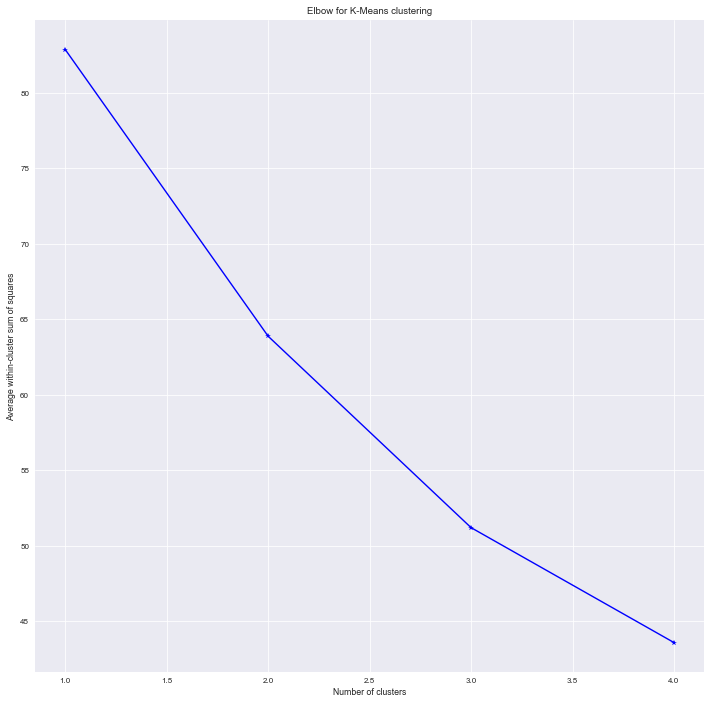

In [69]:
# plot elbow curve showing k=3
plt.plot(K, avgWithinSS, 'b*-')
plt.xlabel('Number of clusters');
plt.ylabel('Average within-cluster sum of squares');
plt.title('Elbow for K-Means clustering');